In [1]:
import librosa
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import warnings
warnings.filterwarnings('ignore')

audio_path = '/Users/jproza/Enjoy the Silence/hip.00000.wav'
x , sr = librosa.load(audio_path,sr=44100)
print(type(x), type(sr))
print(x.shape)
##x.reshape(1323008,)


<class 'numpy.ndarray'> <class 'int'>
(1323008,)


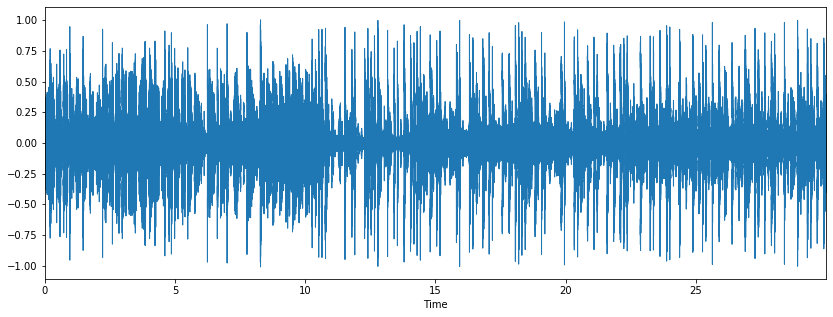

In [2]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

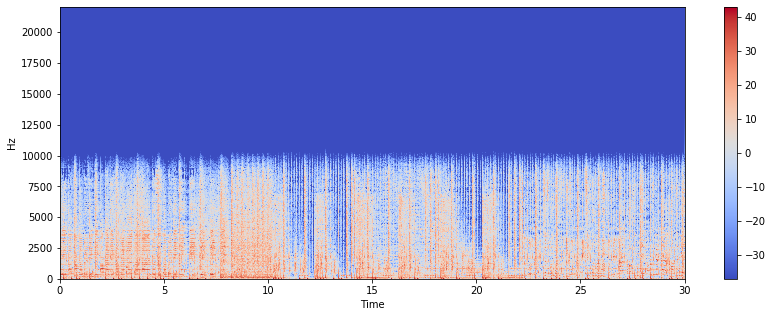

In [3]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

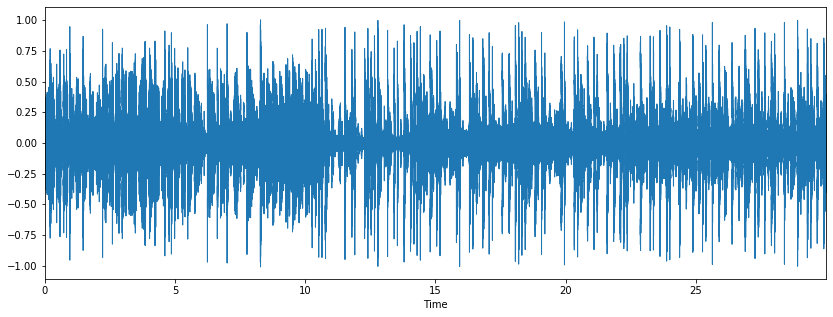

In [4]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

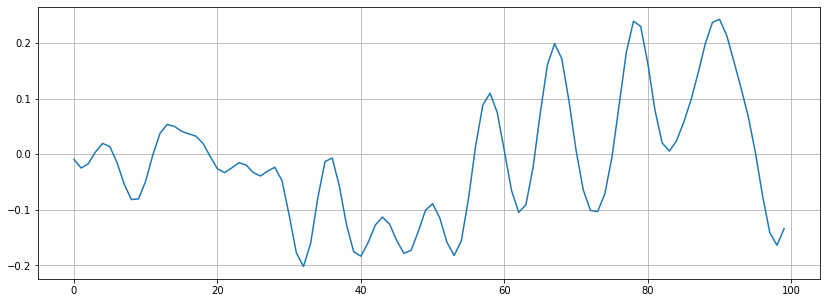

In [5]:
# Zooming in
n0 = 1000
n1 = 1100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [6]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

10


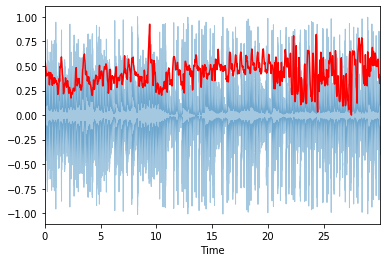

In [7]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound

spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

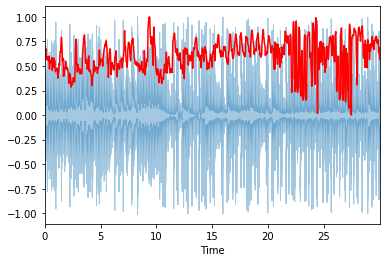

In [8]:
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 2585)


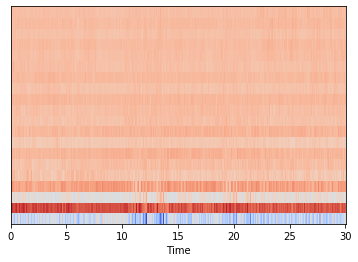

In [9]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [4]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
import keras

In [5]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [6]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/Users/jproza/Downloads/genres/{g}'):
        songname = f'/Users/jproza/Downloads/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jproza/Downloads/genres/classical'

In [ ]:
data = pd.read_csv('data.csv')
data.head()

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head()

In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)
classes= list(encoder.classes_)

from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(genre_list))


In [ ]:
print(y.shape)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [ ]:
X = np.stack(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.5)

In [ ]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

In [ ]:
predictions = model.predict(X_test)
for i in range(len(predictions)): 
    ndex=np.argmax(i)
    print(classes[ndex],predictions[i])


In [ ]:
import IPython.display as ipd
def predict(s):
    #print ((X_train.shape[1],))
    prob=model.predict(X_train)
    for p in prob:
        index=np.argmax(p)
        print(classes[index])

In [ ]:
import IPython.display as ipd
def predict23(s):
    #print ((X_train.shape[1],))
    prob=model.predict(X_train)
    for p in prob:
        r =np.argmax(p).ravel()
        #print(r)
        ipd.Audio(r, rate=sr/2)

In [ ]:
samples, sample_rate = librosa.load('/Users/jproza/Downloads/genres/metal/metal.00006.wav', sr = 26000)
samples = librosa.resample(samples, sr,(sr/2))
samples=samples.ravel()
ipd.Audio(samples,rate=(sr/2))

In [ ]:
predict23(samples)
#predict(samples)

In [ ]:
predictions = model.predict(X_test)
predictions[0].shape
np.sum(predictions[0])
classes[np.argmax(predictions[199])]

In [52]:
print(model.predict_classes(X_test))

[5 6 5 0 4 5 9 1 0 5 4 1 1 1 7 7 6 5 1 0 8 0 3 3 9 3 1 8 1 4 7 2 4 8 4 0 1
 1 0 9 3 5 2 6 8 5 3 7 3 1 8 0 5 3 2 4 3 2 7 9 4 3 0 8 7 4 5 0 0 8 1 3 0 5
 6 7 3 9 2 4 8 2 7 6 4 9 0 9 0 5 5 1 0 1 2 6 8 8 2 6 2 5 2 6 9 8 9 5 4 8 9
 7 1 5 9 0 1 8 3 8 1 2 3 6 1 7 4 5 8 7 9 9 1 6 5 4 9 5 0 9 5 4 0 1 2 7 5 3
 1 3 8 0 4 1 6 6 7 2 8 8 3 0 0 7 5 3 2 3 2 8 4 7 1 7 7 9 2 9 8 8 4 8 9 7 1
 3 6 7 4 4 8 1 0 7 0 5 4 7 1 8]


In [ ]:
model.predict_classes(X_test).shape

In [73]:
import random
index=random.randint(0,len(X_test)-1)
samples=X_test[23].ravel()
#print("Audio:",classes[np.argmax(X_test[index])])
ipd.Audio(samples, rate=sr/2)